In [1]:
import pandas as pd
import csv
import os,sys,json
from datetime import datetime, timedelta, date
import matplotlib
import matplotlib.pylab as plt
import re
from pylab import *
import tqdm
import numpy as np
%matplotlib inline
font = {'family' : 'Noto Sans CJK JP'}
matplotlib.rc('font', **font)

In [2]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [3]:
def display_full(df):
    max_rows = pd.get_option('display.max_rows')
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', max_rows)

In [4]:
!mkdir -p data/google/forecasts
!wget https://storage.googleapis.com/covid-external/forecast_STATE_28.csv -O data/google/forecasts/forecast_STATE_28-`date +%Y%m%d`.csv

--2021-05-12 12:06:43--  https://storage.googleapis.com/covid-external/forecast_STATE_28.csv
storage.googleapis.com (storage.googleapis.com) をDNSに問いあわせています... 2404:6800:4004:811::2010, 2404:6800:4004:812::2010, 2404:6800:4004:80a::2010, ...
storage.googleapis.com (storage.googleapis.com)|2404:6800:4004:811::2010|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 563376 (550K) [application/octet-stream]
`data/google/forecasts/forecast_STATE_28-20210512.csv' に保存中

data/google/forecas 100%[===================>] 550.17K  --.-KB/s    in 0.06s   

2021-05-12 12:06:43 (8.33 MB/s) - `data/google/forecasts/forecast_STATE_28-20210512.csv' へ保存完了 [563376/563376]



In [5]:
target_date = datetime.datetime.now().strftime("%Y%m%d")
df = pd.read_csv("data/google/forecasts/forecast_STATE_28-%s.csv"%target_date)
df.set_index("target_prediction_date").sort_index()

,state_fips_code,state_name,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,cumulative_deaths,cumulative_deaths_q0025,cumulative_deaths_q0975,hospitalized_patients,hospitalized_patients_q0025,...,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,intensive_care_patients_ground_truth,recovered_ground_truth,ventilator_patients_ground_truth,forecast_date,new_deaths,new_confirmed,new_deaths_ground_truth,new_confirmed_ground_truth
target_prediction_date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,25,MASSACHUSETTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17406.0,643.0,175.0,NaN,NaN,2021-05-09,NaN,NaN,NaN,NaN
2021-04-12,47,TENNESSEE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12015.0,902.0,263.0,NaN,NaN,2021-05-09,NaN,NaN,NaN,NaN
2021-04-12,40,OKLAHOMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6669.0,309.0,67.0,NaN,NaN,2021-05-09,NaN,NaN,NaN,NaN
2021-04-12,36,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51204.0,4965.0,972.0,NaN,NaN,2021-05-09,NaN,NaN,NaN,NaN
2021-04-12,29,MISSOURI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8887.0,772.0,178.0,NaN,NaN,2021-05-09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06,19,IOWA,3.742503e+05,3.726995e+05,3.940562e+05,6064.703125,6036.833008,6339.389648,74.080482,73.125740,...,NaN,NaN,NaN,NaN,NaN,2021-05-09,1.814453,133.937500,NaN,NaN
2021-06-06,44,RHODE ISLAND,1.527226e+05,1.520866e+05,1.608718e+05,2747.761230,2735.120850,2873.763184,88.574142,87.390388,...,NaN,NaN,NaN,NaN,NaN,2021-05-09,1.435791,95.000000,NaN,NaN
2021-06-06,18,INDIANA,7.557671e+05,7.526058e+05,7.960998e+05,13749.776367,13686.574219,14373.902344,449.192261,443.319794,...,NaN,NaN,NaN,NaN,NaN,2021-05-09,8.720703,710.250000,NaN,NaN


In [6]:
df.columns

Index(['state_fips_code', 'state_name', 'target_prediction_date',
       'cumulative_confirmed', 'cumulative_confirmed_q0025',
       'cumulative_confirmed_q0975', 'cumulative_deaths',
       'cumulative_deaths_q0025', 'cumulative_deaths_q0975',
       'hospitalized_patients', 'hospitalized_patients_q0025',
       'hospitalized_patients_q0975', 'intensive_care_patients',
       'intensive_care_patients_q0025', 'intensive_care_patients_q0975',
       'recovered', 'recovered_q0025', 'recovered_q0975',
       'ventilator_patients', 'ventilator_patients_q0025',
       'ventilator_patients_q0975', 'cumulative_confirmed_ground_truth',
       'cumulative_deaths_ground_truth', 'hospitalized_patients_ground_truth',
       'intensive_care_patients_ground_truth', 'recovered_ground_truth',
       'ventilator_patients_ground_truth', 'forecast_date', 'new_deaths',
       'new_confirmed', 'new_deaths_ground_truth',
       'new_confirmed_ground_truth'],
      dtype='object')

In [7]:
#total_df = df.loc[~df["new_confirmed"].isnull()].groupby("target_prediction_date").sum()
total_df = df.groupby("target_prediction_date").sum()
total_df

,state_fips_code,cumulative_confirmed,cumulative_confirmed_q0025,cumulative_confirmed_q0975,cumulative_deaths,cumulative_deaths_q0025,cumulative_deaths_q0975,hospitalized_patients,hospitalized_patients_q0025,hospitalized_patients_q0975,...,cumulative_confirmed_ground_truth,cumulative_deaths_ground_truth,hospitalized_patients_ground_truth,intensive_care_patients_ground_truth,recovered_ground_truth,ventilator_patients_ground_truth,new_deaths,new_confirmed,new_deaths_ground_truth,new_confirmed_ground_truth
target_prediction_date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31140577.0,560688.0,44919.0,10155.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2021-04-13,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31217455.0,561506.0,45359.0,10218.0,0.0,0.0,0.000000,0.000000,818.0,76878.0
2021-04-14,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31292356.0,562467.0,47187.0,10202.0,0.0,0.0,0.000000,0.000000,961.0,74901.0
2021-04-15,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31365521.0,563363.0,45021.0,10043.0,0.0,0.0,0.000000,0.000000,896.0,73165.0
2021-04-16,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31443868.0,564224.0,45290.0,10133.0,0.0,0.0,0.000000,0.000000,861.0,78347.0
2021-04-17,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31495105.0,564909.0,44578.0,10110.0,0.0,0.0,0.000000,0.000000,685.0,51237.0
2021-04-18,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31535771.0,565233.0,45020.0,10267.0,0.0,0.0,0.000000,0.000000,324.0,40666.0
2021-04-19,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31602590.0,565719.0,45883.0,10443.0,0.0,0.0,0.000000,0.000000,486.0,66819.0
2021-04-20,1477,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31663303.0,566542.0,46133.0,10582.0,0.0,0.0,0.000000,0.000000,823.0,60713.0


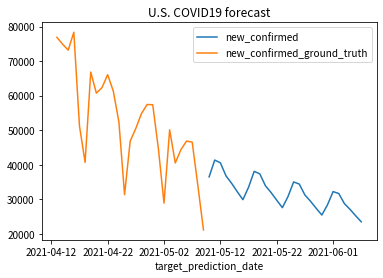

In [8]:
!mkdir -p google-covid19-forecast/us/
ax=total_df.replace(0, np.nan).plot(title="U.S. COVID19 forecast", y=["new_confirmed","new_confirmed_ground_truth"])
display(ax.figure)
plt.savefig("google-covid19-forecast/us/USA-total.png")
plt.close()

In [9]:
if False:
    for p, ddf in df.groupby("state_name"):
        ax=ddf.set_index("target_prediction_date").sort_index().plot(title=p, y=["new_confirmed","new_confirmed_ground_truth"])
        display(ax.figure)
        plt.savefig("google-covid19-forecast/%s.png"%p)
        plt.close()

In [10]:
from functools import reduce

def read_one_week():
    today = datetime.datetime.now()
    stable_cols = ("target_prediction_date", "state_name", "new_confirmed_ground_truth")
    def data_for_date(target_date):
        filename = "data/google/forecasts/forecast_STATE_28-%s.csv"%target_date
        if not os.path.exists(filename):
            return None
        ddf = pd.read_csv(filename)
        result = ddf[[
            "target_prediction_date", "state_name", 
            "new_confirmed_ground_truth", "new_confirmed"]]
        result["target_prediction_date"] = pd.to_datetime(result["target_prediction_date"])
        columns={ 
            c: "%s_%s"%(c, target_date) if c not in stable_cols else c for c in result.columns 
        }
        result = result.rename(columns=columns)
        return result
    
    dates = [(today - datetime.timedelta(days=i)).strftime("%Y%m%d") for i in range(6, -1, -1)]
    data  = [data_for_date(d) for d in dates]
    truth = [d[1].set_index(['target_prediction_date', 'state_name'])["new_confirmed_ground_truth"].rename(d[0]) for d in zip(dates, data) if not d[1] is None]
    truth = reduce(lambda l, r: pd.merge(l, r, on=['target_prediction_date', 'state_name'], how='outer'), truth)
    if len(truth.shape) > 1 and truth.shape[-1] > 1:
        truth = truth.max(axis=1)
    truth = truth.reset_index().set_index("target_prediction_date").sort_index()
    truth_avg = truth.groupby("state_name").rolling(7, center=True, min_periods=1).mean()
    truth_avg = truth_avg.reset_index().set_index(["target_prediction_date", "state_name"]).sort_index()
    truth = truth.reset_index().set_index(["target_prediction_date", "state_name"]).sort_index()
    truth = pd.concat([truth,truth_avg], axis=1, ignore_index=True)
    truth = truth.rename(columns={0: "new_confirmed", 1: "new_confirmed(avg)"})
    data = [d.drop(columns="new_confirmed_ground_truth") for d in data if not d is None]
    data = [truth] + data
    return reduce(lambda l, r: pd.merge(l, r, on=['target_prediction_date', 'state_name'], how='outer'), data)
weekly_comparison = read_one_week()
display(weekly_comparison)

<ipython-input-10-3df97c09fba3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["target_prediction_date"] = pd.to_datetime(result["target_prediction_date"])


,target_prediction_date,state_name,new_confirmed,new_confirmed(avg),new_confirmed_20210512
0,2021-04-12,ALABAMA,NaN,710.000000,NaN
1,2021-04-12,ALASKA,NaN,183.333333,NaN
2,2021-04-12,ARIZONA,NaN,496.333333,NaN
3,2021-04-12,ARKANSAS,NaN,242.333333,NaN
4,2021-04-12,CALIFORNIA,NaN,2551.000000,NaN
...,...,...,...,...,...
2851,2021-06-06,VIRGINIA,NaN,NaN,614.937500
2852,2021-06-06,WASHINGTON,NaN,NaN,730.312500
2853,2021-06-06,WEST VIRGINIA,NaN,NaN,231.625000
2854,2021-06-06,WISCONSIN,NaN,NaN,317.437500


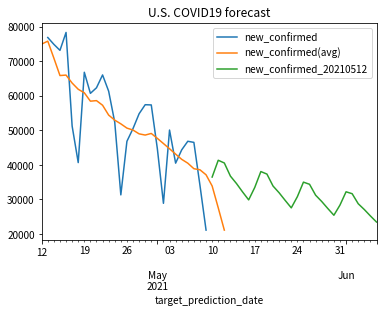

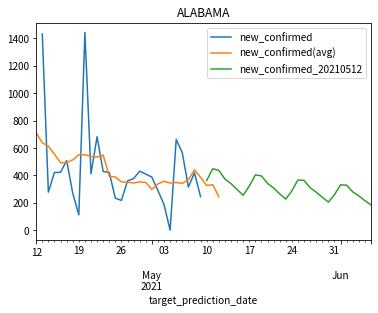

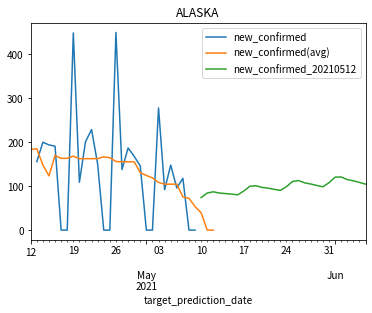

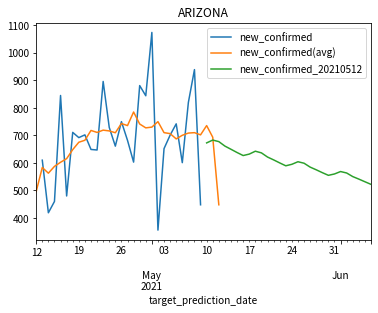

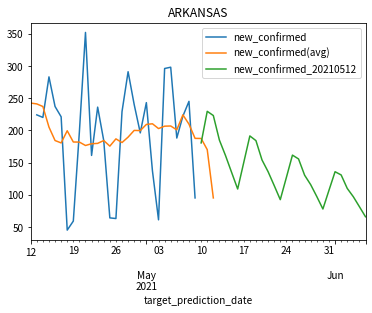

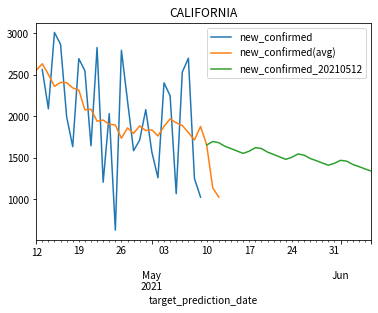

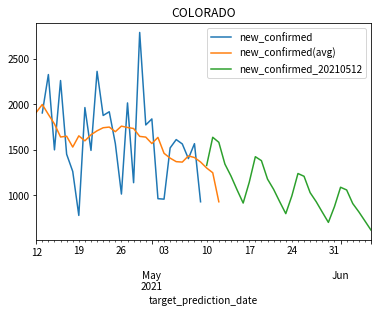

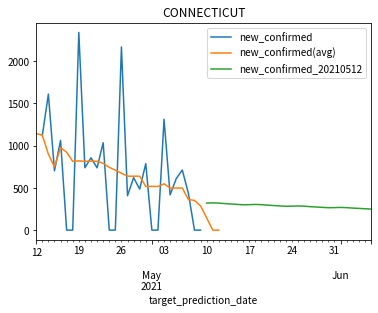

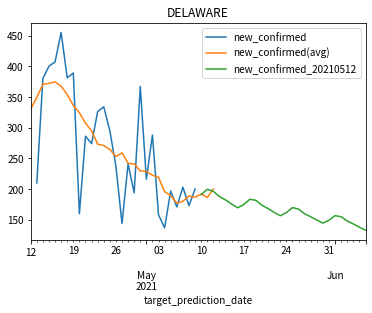

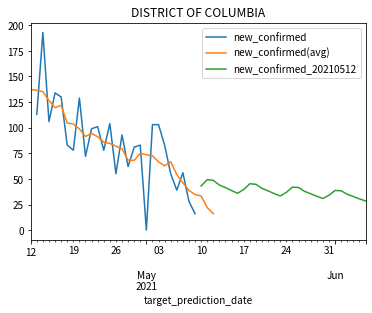

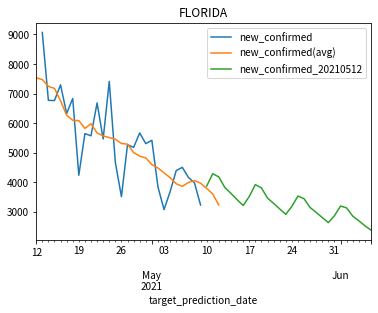

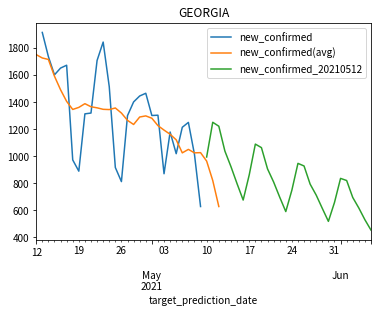

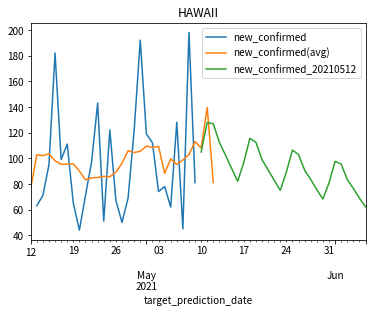

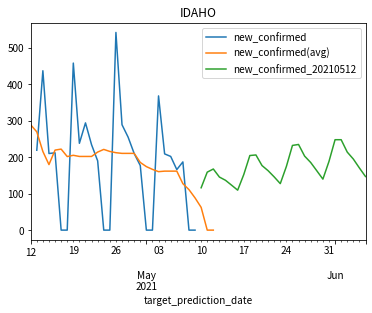

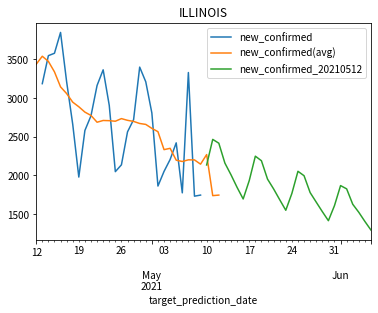

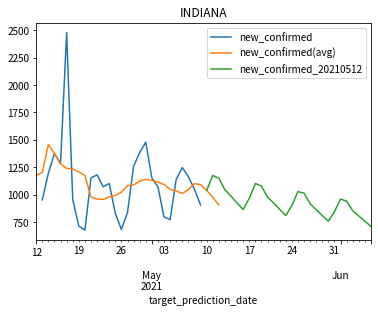

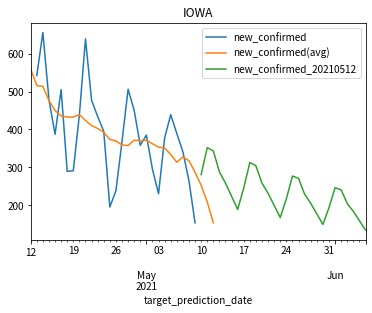

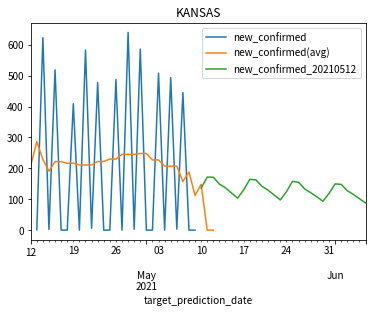

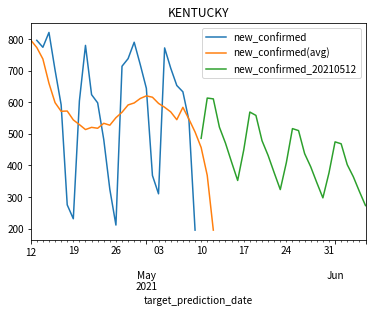

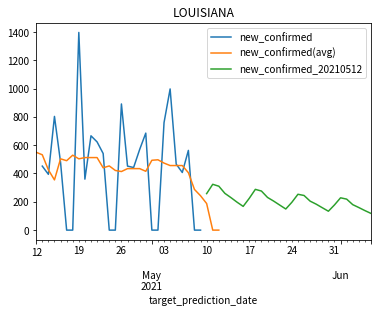

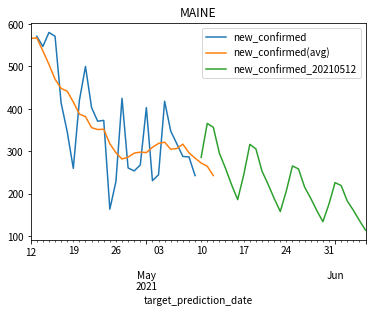

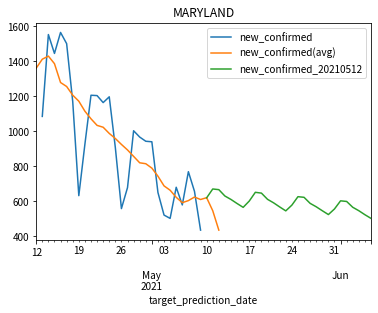

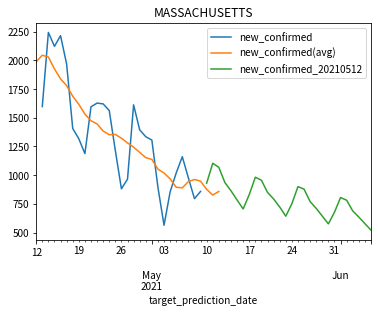

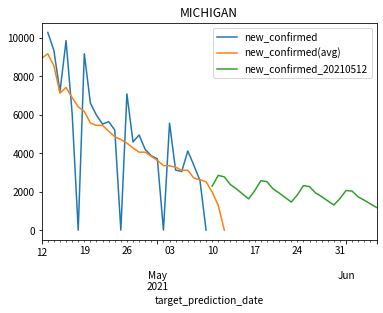

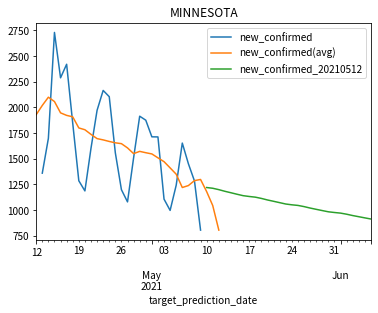

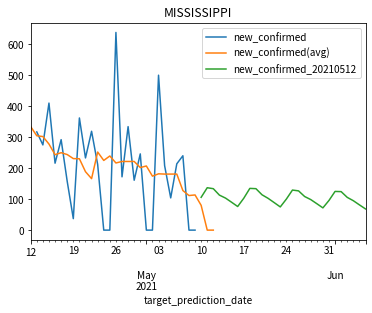

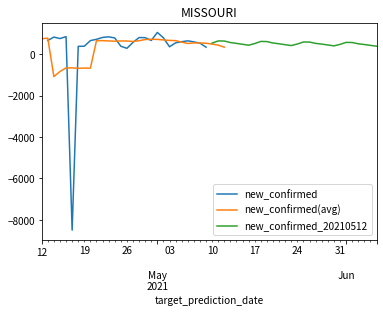

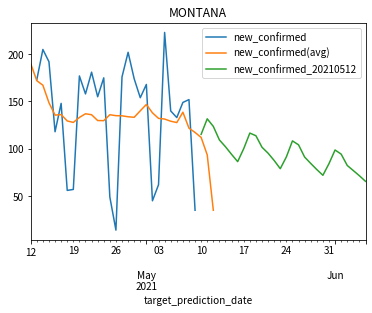

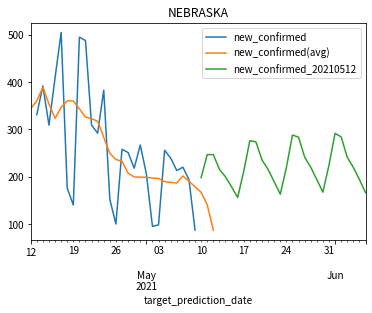

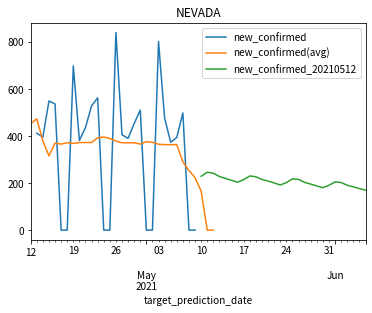

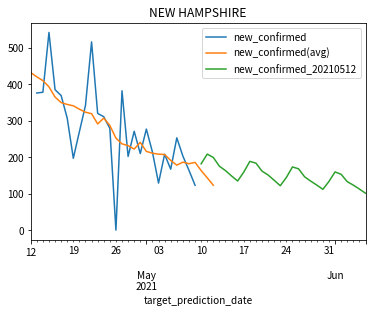

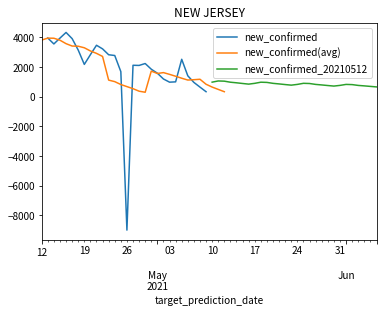

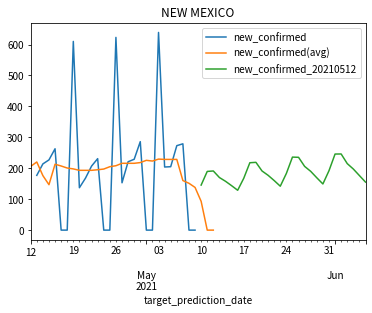

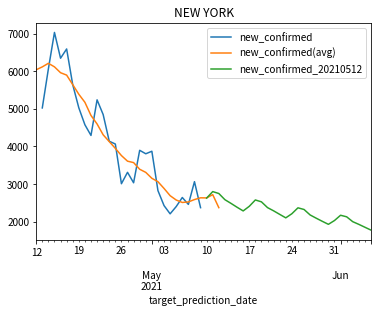

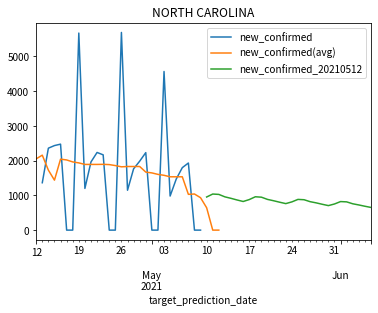

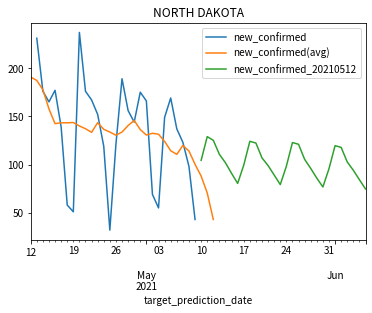

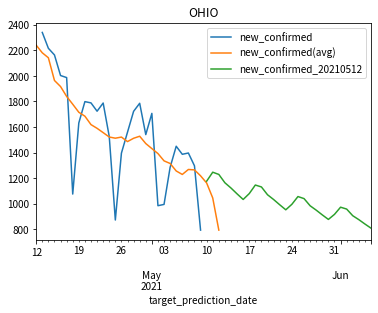

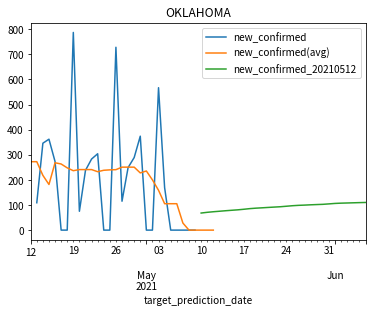

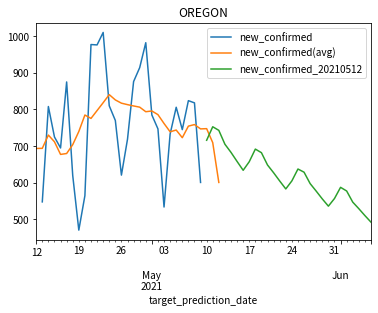

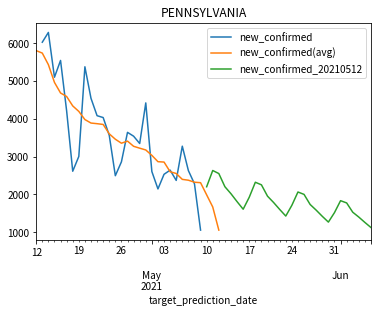

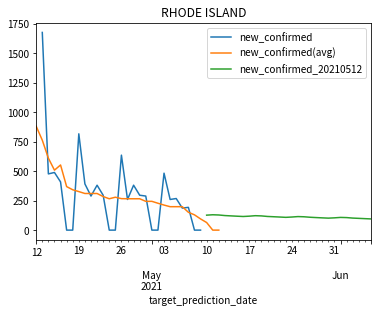

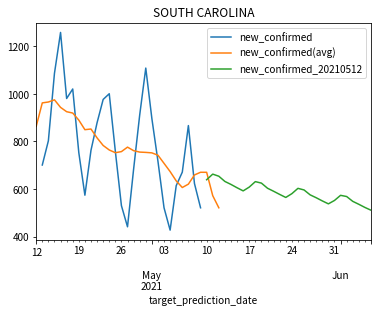

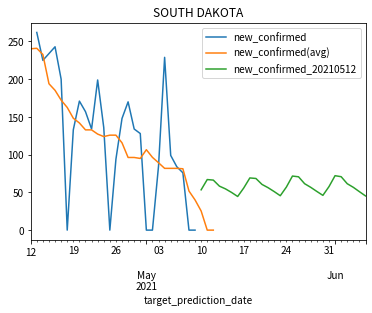

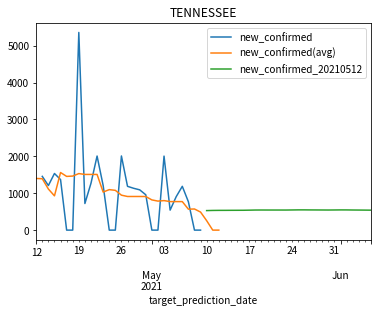

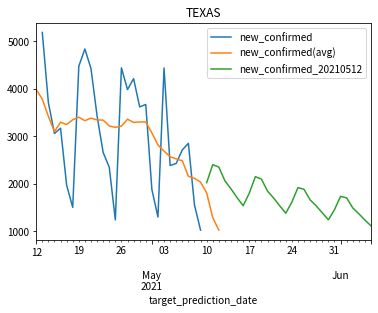

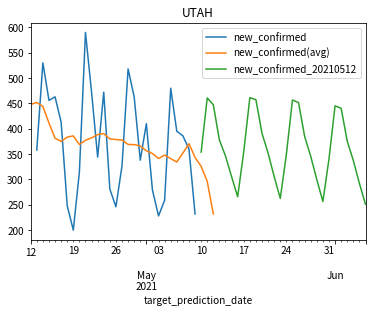

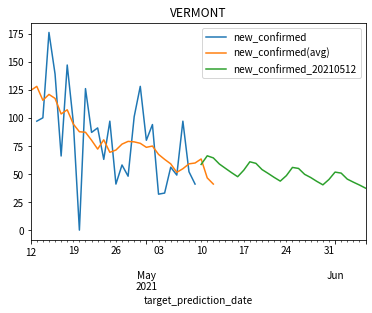

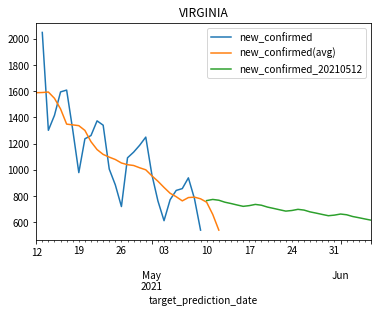

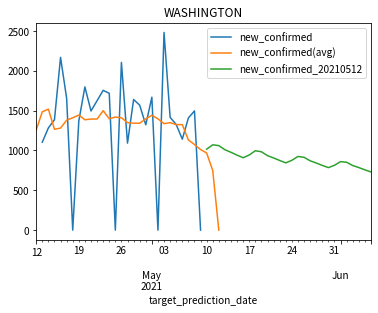

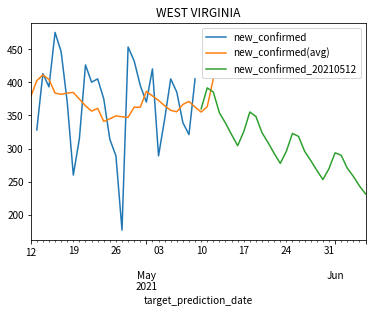

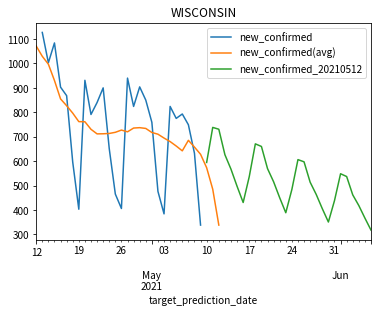

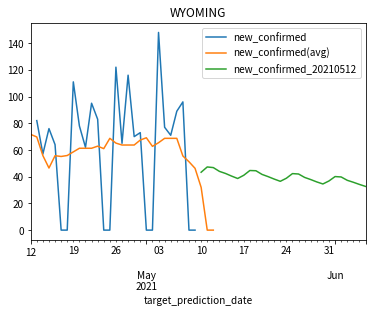

In [11]:
!mkdir -p google-covid19-forecast/us/

ax = weekly_comparison.groupby("target_prediction_date").sum().replace(0, np.nan).plot(title="U.S. COVID19 forecast")
display(ax.figure)
plt.savefig("google-covid19-forecast/us/USA-weekly.png")
plt.close()



for p, ddf in weekly_comparison.groupby("state_name"):
    ax=ddf.set_index("target_prediction_date").sort_index().plot(title=p)
    display(ax.figure)
    plt.savefig("google-covid19-forecast/us/%s-weekly.png"%p)
    plt.close()

In [12]:
!zip google-covid19-forecast-us.zip google-covid19-forecast/us/*

updating: google-covid19-forecast/us/ALABAMA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ALASKA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ARIZONA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ARKANSAS-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/CALIFORNIA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/COLORADO-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/CONNECTICUT-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/DELAWARE-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/DISTRICT OF COLUMBIA-weekly.png (deflated 2%)
updating: google-covid19-forecast/us/FLORIDA-weekly.png (deflated 4%)
updating: google-covid19-forecast/us/GEORGIA-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/HAWAII-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/IDAHO-weekly.png (deflated 3%)
updating: google-covid19-forecast/us/ILLINOIS-weekly.png (deflated 3%)
